In [4]:
mari, juksemari = Contributor.objects.filter(display_name__icontains='Haanshus')

In [ ]:
from fuzzywuzzy import process
from django.db.models import Count
contributors = Contributor.objects.annotate(
        num_bylines=Count('byline')
    ).order_by('-num_bylines')
everyone = Contributor.objects.values_list('display_name', flat=True)
for contributor in contributors[:100]:
    best = process.extract(contributor.display_name, everyone, limit=3)
    print(best)
    

In [69]:
from collections import Counter
attr = '_size'
dupes = Counter(ImageFile.objects.values_list(attr, flat=True))
print(len(dupes))
duped_values = [el for el in dupes if dupes[el] > 1]
for value in duped_values:
    images = ImageFile.objects.filter(**{attr: value}).order_by('-full_width','-created')
    print()
    for img in images:
        print('{id} {_md5} {_size:>8} {full_width:>4}x{full_height:<4} {_imagehash} {created:%H:%M} {source_file}'.format(**img.__dict__))
    #merge_instances(*images) 

1962

37219 a9353463ceb21770d1b51307352cfc7f   166041 1500x2250 2211b4b431b20e4d 20:23 byline-photo/Eskil-Wie.jpg
32034 963347a6a4c52d91eb5654cc6d362f95   166041 1500x1605 b970646071b0c212 01:10 byline-photo/Hans-Dalane-Hval.jpg

41905 00be4903994302c723cfc3f252b51cc1   178244 1500x1000 4f4f4302d3992b2b 15:58 2017/11/11-MAG-forstehomofilekirkebryllup-KEK-9.jpg
39794 62117a73ac4e65a2008c8ecc525e9a90   178244 1500x1000 9133e72829cd2896 09:48 2017/1/01-KUL-Digitaleskamen-AN.jpg

40371 c56713d787f1945421ed6fea248baeeb   115520 1500x1000 b3919d1d15616575 13:02 2017/4/04-NYH-Hilde-Mari-Bjorke-AS3.jpg
39884 4ccad6c49d7b96660a679bb5d3c8f696   115520 1500x1500 92323a3290901418 14:35 2017/2/kinejd.jpg

40511 5d92ce158af8ac0f2faace772a7676ae   193433 1500x1000 b4a472b47862320c 14:57 2017/5/04-KUL-bareegil-SN-1.jpg
40275 d5488612642b2c319fed257bf0ed936b   193433 1500x2250 3b860e8f47176933 17:02 2017/4/DSC-3644-copy.jpg

41753 017071d5023e6c15f6e189ff285a64f0   182501 1500x1000 7b242c2d1cb971cd 18:

In [165]:
dupe_files = [ImageFile.objects.filter(source_file=d['source_file']).order_by('-_size') for d in dupes]
for qs in dupe_files:
    print()
    for img in qs:
        img.imghash = hash_img(img)
        print('{id} {_md5} {_size:>8} {full_width:>4}x{full_height:<4} {imghash} {source_file}'.format(**img.__dict__))
    


41328 f601e969ea344acaefe7d95aef0b1b19   356760 1610x1020 b072716949597965 2017/7/hedvig.jpg
41234 93584a46de990cd257be0da2550ef6ae   105476 1500x950  b072716949597965 2017/7/hedvig.jpg

41547 28e486422a95f68a4c3ce02b453aa894  2357490 2500x1667 2d2c2d2539345ab3 2017/8/08-NYH-thomasevensen-AN-1.jpg
41538 78c71654c69de46f0268de3e7d976fdd   222192 1500x1000 2d2c2d2539345ab3 2017/8/08-NYH-thomasevensen-AN-1.jpg

40848 ca4c0f6fe7c7a10f6a290f40841dfbd3  3291804 2500x1606 a4b4b3b2d2b4d6d8 2017/6/03-NYH-graver-AN-1-2.jpg
40204 3311598eb0e2eeac28f79887901863a1   176641 1500x964  a4b4b3b2d2b4d6d8 2017/6/03-NYH-graver-AN-1-2.jpg

41546 43a3faa1bd53cdaa4102b96acff18d96  2202531 2500x1667 2d2de6d2b226d343 2017/8/08-NYH-DNSoppslag-SN-04.jpg
41491 88db53d265c19c16b002f2e70087982b   285852 1500x1000 2d2de6d2b226d343 2017/8/08-NYH-DNSoppslag-SN-04.jpg

41051 c80a853bee20dffa8872a98ecb8a893c 13697750 5616x3744 0f0f4f4d9edcb2c6 2017/6/07-NYH-rektor-AN-1-2.jpg
41012 5a7afd8b4afafae42aa5cc87f10cbcb4   130

In [163]:
def pil_img(instance, size=8):
    with instance.source_file as fp:
        if fp.closed:
            fp.open()
        img = Image.open(fp).convert('L').resize((size,size))
    return img

def hash_img(instance):
    return str(imagehash.dhash(pil_img(instance)))


phash 0b12e2e56e4c7d39 0b12e2e56e4c7d39 0
dhash 9d4b8db92d6c4d21 9d4b8db92d6c4d21 0
whash 001e18236ad3df7f 001e18236bc3df7f 2


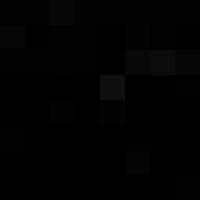

In [157]:
from PIL import ImageChops
img1 = pil_img(imgfile, size)
img2 = cv_img(imgfile, size)
hashfuncs = imagehash.phash, imagehash.dhash, imagehash.whash
for func in hashfuncs:
    hash1 = func(img1)
    hash2 = func(img2)
    print(func.__name__, hash1, hash2, hash1-hash2)

ImageChops.difference(img1, img2).resize((200,200))

In [156]:
%timeit imagehash.dhash(img1)
%timeit imagehash.whash(img1)
%timeit imagehash.phash(img1)

69.5 µs ± 5.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
964 µs ± 33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
469 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
im0 = cv_img(ImageFile.objects.first())
for fn in dupe_files:
    im1, im2 = ImageFile.objects.filter(source_file=fn)[:2]
    diff = mse(cv_img(im1), cv_img(im2))
    print(diff)
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [21]:
!pip install --user imagehash

  Using cached PyWavelets-0.5.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached scipy-0.19.0-cp36-cp36m-manylinux1_x86_64.whl


In [1]:
from PIL import Image

import imagehash



In [7]:
from sorl import thumbnail
def make_thumb(imf, width=8, height=8):
    

make_thumb(ImageFile.objects.first())

In [12]:
_7.x

5

In [49]:
from django.db import transaction
from django.apps import apps
from django.contrib.contenttypes.fields import GenericForeignKey
from django.db.models.fields.related import ManyToManyField

@transaction.atomic()
def merge_instances(primary_object, *alias_objects):
    """Merge several model instances into one, the `primary_object`.
    Use this function to merge model objects and migrate all of the related
    fields from the alias objects the primary object.
    Usage:
        from django.contrib.auth.models import User
        primary_user = User.objects.get(email='good@example.com')
        duplicate_user = User.objects.get(email='good+duplicate@example.com')
        merge(primary_user, duplicate_user)
    Based on: https://djangosnippets.org/snippets/382/
    """
    generic_fields = get_generic_fields()

    # get related fields
    many_to_many_fields, related_fields = discrimine(
        lambda field: isinstance(field, ManyToManyField),
        primary_object._meta._get_fields(forward=False, include_hidden=True)
    )

    # Loop through all alias objects and migrate their references to the
    # primary object
    for alias_object in alias_objects:
        # Migrate all foreign key references from alias object to primary
        # object.
        for related_object in related_fields:
            # The variable name on the alias_object model.
            alias_varname = related_object.get_accessor_name()
            # The variable name on the related model.
            obj_varname = related_object.field.name
            related_objects = getattr(alias_object, alias_varname)
            for obj in related_objects.all():
                setattr(obj, obj_varname, primary_object)
                obj.save()

        # Migrate all many to many references from alias object to primary
        # object.
        for related_many_object in many_to_many_fields:
            alias_varname = related_many_object.get_accessor_name()
            obj_varname = related_many_object.field.name
            related_many_objects = getattr(alias_object, alias_varname)
            for obj in related_many_objects.all():
                getattr(obj, obj_varname).remove(alias_object)
                getattr(obj, obj_varname).add(primary_object)

        # Migrate all generic foreign key references from alias object to
        # primary object.
        for field in generic_fields:
            filter_kwargs = {}
            filter_kwargs[field.fk_field] = alias_object._get_pk_val()
            filter_kwargs[field.ct_field] = field.get_content_type(alias_object)
            related_objects = field.model.objects.filter(**filter_kwargs)
            for generic_related_object in related_objects:
                setattr(generic_related_object, field.name, primary_object)
                generic_related_object.save()

        if alias_object.id:
            alias_object.delete()

    return primary_object


def get_generic_fields():
    """Return a list of all GenericForeignKeys in all models."""
    generic_fields = []
    for model in apps.get_models():
        for field_name, field in model.__dict__.items():
            if isinstance(field, GenericForeignKey):
                generic_fields.append(field)
    return generic_fields


def discrimine(pred, sequence):
    """Split a collection in two collections using a predicate.
    >>> discrimine(lambda x: x < 5, [3, 4, 5, 6, 7, 8])
    ... ([3, 4], [5, 6, 7, 8])
    """
    positive, negative = [], []
    for item in sequence:
        if pred(item):
            positive.append(item)
        else:
            negative.append(item)
    return positive, negative
